## <center><font color = 'green'> RandomJungle </font></center>

### Librairies Python

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import sklearn as skl

### Jeux de données artificiel

In [35]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 60000 , 
                           n_features = 25 , 
                           n_informative = 15 ,
                           n_redundant = 0 , 
                           n_repeated = 0 , 
                           n_classes = 2 ,
                           n_clusters_per_class = 1 ,
                           weights =[ 0.99 , 0.01 ] ,
                           class_sep = 0.8 , 
                           random_state = 0 )


### Transformations en dataframe (classes déséquilibrées)

In [36]:
# Variables explicatives :

X_var = [ 'x_' + str( k ) for k in range( 0 , X.shape[1] ) ]

# Variable à expliquer :

y_var = [ 'y' ]

# Dataframes : 

df_X = pd.DataFrame( X , columns = X_var )

df_y = pd.DataFrame( y , columns = y_var )

### Empilement de df_X et df_y

In [37]:
df = pd.concat( [ df_X , df_y ] , axis = 1 )

## Modèles

In [38]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

In [39]:
df_train_all , df_test = train_test_split( df , train_size = 0.9 )

df_train_0 = df_train_all[ df_train_all[ 'y' ] == 0 ]
df_train_1 = df_train_all[ df_train_all[ 'y' ] == 1 ]

print( 'df_train_all : {0}'.format( df_train_all.shape ) )
print( 'df_train_0 : {0}'.format( df_train_0.shape ) )
print( 'df_train_1 : {0}'.format( df_train_1.shape ) )

print( 'df_test : {0}'.format( df_test.shape ) )


df_train_all : (54000, 26)
df_train_0 : (53201, 26)
df_train_1 : (799, 26)
df_test : (6000, 26)


C:\Users\FAB\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [40]:
# train dataset :

df_X_train_all = df_train_all[ X_var ]
df_y_train_all = df_train_all[ y_var ]

X_train_all = df_X_train_all.values
y_train_all = np.ravel( df_y_train_all.values )

# test dataset :

df_X_test = df_test[ X_var ]
df_y_test = df_test[ y_var ]

X_test = df_X_test.values
y_test = np.ravel( df_y_test.values )

### Baseline

In [41]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import pickle

In [59]:
# Modèle de référence ( RandomForest ) pour comparaison avec modèle cible ( RandomJungle )

lst_bsl_auc = []

lst_bsl_cfu_mtx = []

clf = RandomForestClassifier( n_estimators = 10 )

clf.fit( X_train_all , y_train_all )

# Sauvegarde du modèle sur disque
filename = './mdl/_mdl' + '.sav'
pickle.dump( clf , open( filename , 'wb' ) )
    
    
# Prédictions sur test dataset
y_test_pred = clf.predict( X_test )
    
# Matrice de confusion sur test dataset
cfu_mtx = confusion_matrix( y_test , y_test_pred )

lst_bsl_cfu_mtx = lst_bsl_cfu_mtx.append( cfu_mtx )
    
# AUC sur test dataset
auc = roc_auc_score( y_test , y_test_pred )

lst_bsl_auc = lst_bsl_auc.append( auc )
    
#print( 'confusion matrix (test dataset):\n {0}'.format( cfu_mtx ) )
print( 'baseline model : auc (test dataset) : \n {0}'.format( auc ) )
print( 'baseline model : confusion matrix (test dataset) : \n {0}'.format( cfu_mtx ) )


auc (test dataset) : 
 0.5807233494066234
confusion matrix : 
 [[5900    1]
 [  83   16]]


### <font : color = 'orange'> RandomJungle </font>

### K RandomForest = RandomJungle

In [43]:

# Nbr de modèles :

K = 100

# Taille des échantillons à mettre en face des fraudes :

spl_siz = len( df_train_1.index )

# Matrice de confusion et AUC sur ( X_test , y_test ) pour info

lst_cfu_mtx = []
lst_auc = []


# prédictions sur train dataset :

pred_train = {}

# Hyper parameters - random grid :

#n_estimators = [ int(x) for x in np.linspace( start = 200 , stop = 1000 , num = 10 ) ]
#max_features = [ 'auto' , 'sqrt' ]
#max_depth = [ int(x) for x in np.linspace( 10 , 110 , num = 11 ) ]
#max_depth.append( None )
#min_samples_split = [ 2 , 5 , 10 ]
#min_samples_leaf = [ 1 , 2 , 4 ]
#bootstrap = [ True , False ]

#random_grid = { 'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap }

# K randomforests
for i in range( 0 , K ) :
    
    # train dataset - échantillon de sinistres non fraude (autant que de sinistres fraude dans le train dataset)
    df_train_0_spl = df_train_0.sample( n =  spl_siz ) 
    # train dataset - concaténation des sinistres fraude et de l'échantillon de sinistres non fraude
    df_tmp = pd.concat( [ df_train_1 , df_train_0_spl ] , axis = 0 )
    
    df_X_train = df_tmp[ X_var ]
    df_y_train = df_tmp[ y_var ]
    
    X_train = df_X_train.values
    y_train = np.ravel( df_y_train.values )
    
    clf0 = RandomForestClassifier( n_estimators = 100 )
    #clf = RandomizedSearchCV( estimator = clf0 , 
    #                          param_distributions = random_grid , 
    #                          n_iter = 100 , 
    #                          cv = 3 , 
    #                          verbose = 2 , 
    #                          random_state = 123 ,
    #                          n_jobs = -1 )
    clf = clf0
    
    clf.fit( X_train , y_train )
    
    # Meilleurs hyper paramètres :
    #print( clf.best_params_ )
    
    # Sauvegarde des modèles sur disque
    filename = './mdl/_mdl_' + str( i ) +'.sav'
    pickle.dump( clf , open( filename , 'wb' ) )
    
    
    # Prédictions sur test dataset
    y_test_pred = clf.predict( X_test )
    
    # Matrice de confusion sur test dataset
    cfu_mtx = confusion_matrix( y_test , y_test_pred )
    lst_cfu_mtx.append( cfu_mtx )
    
    # AUC sur test dataset
    auc = roc_auc_score( y_test , y_test_pred )
    lst_auc.append( auc )
    
    #print( 'confusion matrix (test dataset):\n {0}'.format( cfu_mtx ) )
    print( 'auc (test dataset) : \n {0}'.format( auc ) )
    print( 'confusion matrix : \n {0}'.format( cfu_mtx ) )
    
    
    x_train_pred = clf.predict( X_train )
    col = 'x_pred_' + str( i ) 
    pred_train[ col ] = x_train_pred

# dataframe des prédictions : df_X_train_pred ( utile ? )
df_X_train_pred = pd.DataFrame( pred_train )
df_X_train_pred = df_X_train_pred[ sorted( df_X_train_pred.columns ) ]

auc (test dataset) : 
 0.7241453682734821
confusion matrix : 
 [[4970  931]
 [  39   60]]
auc (test dataset) : 
 0.7330781120816708
confusion matrix : 
 [[4837 1064]
 [  35   64]]
auc (test dataset) : 
 0.7379411810016792
confusion matrix : 
 [[4954  947]
 [  36   63]]
auc (test dataset) : 
 0.7365187205044856
confusion matrix : 
 [[4818 1083]
 [  34   65]]
auc (test dataset) : 
 0.7465683782409761
confusion matrix : 
 [[4877 1024]
 [  33   66]]
auc (test dataset) : 
 0.727298403454987
confusion matrix : 
 [[4888 1013]
 [  37   62]]
auc (test dataset) : 
 0.761211504983747
confusion matrix : 
 [[4871 1030]
 [  30   69]]
auc (test dataset) : 
 0.7210282797471409
confusion matrix : 
 [[4814 1087]
 [  37   62]]
auc (test dataset) : 
 0.7350782866797102
confusion matrix : 
 [[4801 1100]
 [  34   65]]
auc (test dataset) : 
 0.7507202169123877
confusion matrix : 
 [[4926  975]
 [  33   66]]
auc (test dataset) : 
 0.7315015944909183
confusion matrix : 
 [[4878 1023]
 [  36   63]]
auc (test da

auc (test dataset) : 
 0.7374841449574546
confusion matrix : 
 [[4889 1012]
 [  35   64]]
auc (test dataset) : 
 0.7098591404641227
confusion matrix : 
 [[4861 1040]
 [  40   59]]
auc (test dataset) : 
 0.7392121520235398
confusion matrix : 
 [[4969  932]
 [  36   63]]
auc (test dataset) : 
 0.7177237550903032
confusion matrix : 
 [[4775 1126]
 [  37   62]]
auc (test dataset) : 
 0.733737989965748
confusion matrix : 
 [[4964  937]
 [  37   62]]
auc (test dataset) : 
 0.7328906759511742
confusion matrix : 
 [[4954  947]
 [  37   62]]
auc (test dataset) : 
 0.7401108184026334
confusion matrix : 
 [[4920  981]
 [  35   64]]
auc (test dataset) : 
 0.7399927079642382
confusion matrix : 
 [[4859 1042]
 [  34   65]]


In [14]:
df_auc = pd.DataFrame( lst_auc , columns = [ 'auc' ] )

In [15]:
df_auc.mean()

auc    0.666631
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C005080>]],
      dtype=object)

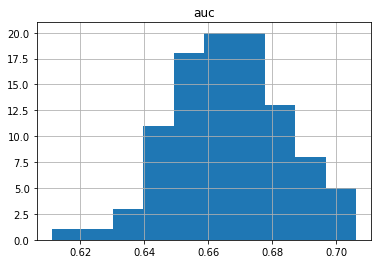

In [16]:
df_auc.hist()

### Prédiction de tous les modèles sur le test dataset ( X_test )

In [44]:
pred = {}

for i in range( 0 , K ) :
    filename = './mdl/_mdl_' + str( i ) + '.sav'
    clf = pickle.load( open( filename , 'rb' ) )
    #x_test_pred = clf.predict_proba( X_test )
    y_test_pred = clf.predict( X_test )
    col = 'y_pred_' + str( i )
    #pred[ col ] = x_test_pred[ : , 0 ]
    pred[ col ] = y_test_pred
    
    
df_X_test_pred = pd.DataFrame( pred )
df_X_test_pred = df_X_test_pred[ sorted( df_X_test_pred.columns ) ]

### Comptabilisation de la proportion de modèles contre

In [45]:
df_X_test_pred[ 'cons' ] = df_X_test_pred.sum( axis = 1 ).apply( lambda x : ( K - x ) / K )

### Vote des RandomForest

In [46]:
df_X_test_pred[ 'y_pred' ] = np.where( df_X_test_pred[ 'cons' ] < 0.50 , 1 , 0 )

In [47]:
df_X_test_pred[ 'y_real' ] = y_test

In [48]:
roc_auc_score( y_test , df_X_test_pred[ 'y_pred' ] )

0.7382107809154071

In [49]:
confusion_matrix( y_test , df_X_test_pred[ 'y_pred' ] )

array([[5136,  765],
       [  39,   60]], dtype=int64)

### AUC Baseline vs RandomJungle

In [23]:
df_auc_versus = pd.DataFrame(  { 'auc_bsl'        : auc , 
                                 'auc_randjgl'    : roc_auc_score( y_test , df_X_test_pred[ 'y_pred' ] ) } ) 

ValueError: If using all scalar values, you must pass an index

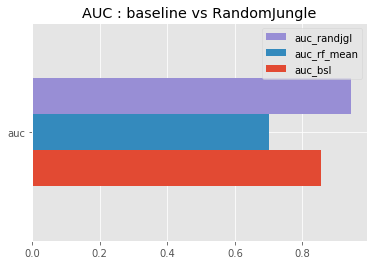

In [204]:
import matplotlib

#df_auc_versus.plot.bar( rot = 360 , width=0.85 , alpha=0.6 , figsize = ( 10 , 8 ) )

df_auc_versus.plot( kind = 'barh' , title = 'AUC : baseline vs RandomJungle' , legend = 'reverse' )